# My Numerical Analysis Algorithm Implementations
○ Cholesky  
○ SVD  
○ Finite Differences ODEs  


In [5]:
using Plots, LinearAlgebra

## Finite Differences

WebIO._IJuliaInit()

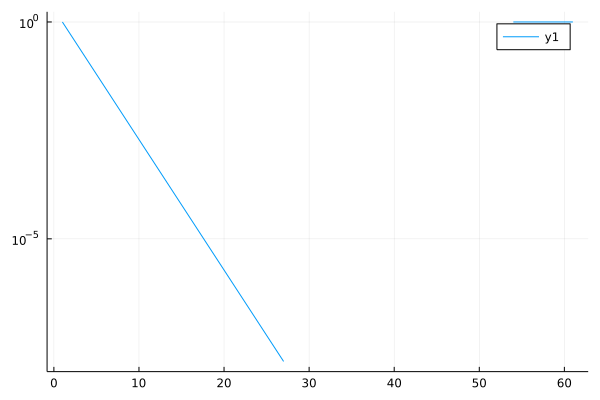

In [7]:
f = x -> 1 + x + x^2
h = 2.0 .^(0:-1:-60)

# Avoid zero division errors
nanabs = x -> iszero(x) ? NaN : abs(x)

plot(nanabs.(((f.(h) .- f(0)) ./ h) .- 1); yscale=:log10)

In [12]:
# As a general rule we use sqrt of machine epsilon for our h
h = sqrt(eps())
println("Error in fd approximation: $(abs(((f(h) - f(0)) / h) - 1))")

Error in fd approximation: 1.4901161193847656e-8


In [22]:
# Central Difference
centraldiff(x, h, f) = (f(x + h) - f(x - h)) / (2*h)
# computes an error, where fp(x) is the true derivative as an analytical function
centraldifferror(x, h, f, fp) = abs(centraldiff(x, h, f) - fp(x))
# Forward Difference
forwarddiff(x, h, f) = (f(x + h) - f(x)) / h
# Backward Difference
backwarddiff(x, h, f) = (f(x) - f(x - h)) / h
# We already implemented central differences in a previous problem
# Second derivative via finite difference
finitediffsecond(x, h, f) = (f(x + h) - 2 * f(x) + f(x - h))/ (h^2)
   
# Define the functions
f = x -> exp(exp(x)cos(x) + sin(x))
g = x -> prod([x] ./ (1:1000) .- 1)
function cont(n, x)  # Continued fraction
   ret = 2*one(x)
   for k = 1:n-1
       ret = 2 + (x-1)/ret
   end
   1 + (x-1)/ret  # Note: this works in reverse
end

cont (generic function with 1 method)

In [23]:
x = 0.1
h = eps()
# Values for exp(exp(x)cos(x) + sin(x))
println("f'($x) with forward difference: ", forwarddiff(x, sqrt(h), f))
println("f'($x) with central difference: ", centraldiff(x, cbrt(h), f))
println("f''($x) via finite difference: ", finitediffsecond(x, cbrt(h), f))
# Values for prod([x] ./ (1:1000) .- 1)
println("g'($x) with forward difference: ", forwarddiff(x, sqrt(h), g))
println("g'($x) with central difference: ", centraldiff(x, cbrt(h), g))
println("g''($x) via finite difference: ", finitediffsecond(x, cbrt(h), g))
# Values for the continued fraction
println("cont'($x) with forward difference: ", forwarddiff(x, sqrt(h), x->cont(1000,x)))
println("cont'($x) with central difference: ", centraldiff(x, sqrt(h), x->cont(1000,x)))
println("cont''($x) via finite difference: ", finitediffsecond(x, cbrt(h), x->cont(1000,x)))

f'(0.1) with forward difference: 6.58477258682251
f'(0.1) with central difference: 6.584772554609315
f''(0.1) via finite difference: 12.002685822813502
g'(0.1) with forward difference: -3.5938262827694416
g'(0.1) with central difference: -3.5938265143690638
g''(0.1) via finite difference: 26.638595097431924
cont'(0.1) with forward difference: 1.5811387598514557
cont'(0.1) with central difference: 1.5811388231813908
cont''(0.1) via finite difference: -7.905698560322122


## Dual Numbers

In [10]:
# Implementation of the Dual type
struct Dual{T}
    a::T
    b::T
end

In [40]:
# Dual(a) represents a + 0*ϵ
Dual(a::Real) = Dual(a, zero(a)) # for real numbers we use a + 0ϵ

# Allow for a + b*ϵ syntax
const ϵ = Dual(0, 1)

import Base: +, *, -, /, ^, zero, exp, sin, cos, log, sqrt, abs, one

# support polynomials like 1 + x, x - 1, 2x or x*2 by reducing to Dual
+(x::Real, y::Dual) = Dual(x) + y
+(x::Dual, y::Real) = x + Dual(y)
-(x::Real, y::Dual) = Dual(x) - y
-(x::Dual, y::Real) = x - Dual(y)
*(x::Real, y::Dual) = Dual(x) * y
*(x::Dual, y::Real) = x * Dual(y)

# support x/2 (but not yet division of duals)
/(x::Dual, k::Real) = Dual(x.a/k, x.b/k)

# a simple recursive function to support x^2, x^3, etc.
function ^(x::Dual, k::Integer)
    if k < 0
        error("Not implemented")
    elseif k == 1
        x
    else
        x^(k-1) * x
    end
end

# support identity of type Dual
one(x::Dual) = Dual(one(eltype(x.a)))

# Algebraic operationds for duals
-(x::Dual) = Dual(-x.a, -x.b)
+(x::Dual, y::Dual) = Dual(x.a + y.a, x.b + y.b)
-(x::Dual, y::Dual) = Dual(x.a - y.a, x.b - y.b)
*(x::Dual, y::Dual) = Dual(x.a*y.a, x.a*y.b + x.b*y.a)
function /(x::Dual, y::Dual)
   if iszero(y.a)
       error("Division for dual numbers is ill-defined when denonimator real part is zero.")
   end
   return Dual(x.a / y.a, (y.a * x.b - x.a * y.b) / y.a^2)
   ## END
end

# Function Implementations
exp(x::Dual) = Dual(exp(x.a), exp(x.a) * x.b)
sin(x::Dual) = Dual(sin(x.a), x.b*cos(x.a))
cos(x::Dual) = Dual(cos(x.a), x.b*sin(x.a)) 
log(x::Dual) = Dual(log(x.a), x.b/x.a)
sqrt(x::Dual) = Dual(sqrt(x.a), x.b/(2*sqrt(x.a)))
abs(x::Dual) = Dual(abs(a), b*sign(x.a))

abs (generic function with 28 methods)

In [41]:
# Using dual numbers to compute derivatives
fdual = f(0.1+ϵ)
println(fdual.b)
gdual = g(0.1+ϵ)
println(gdual.b)
contdual = cont(1000,0.1+ϵ)
println(contdual.b)

7.3170307864221
-3.593826513101571
1.5811388300841893


In [43]:
# Newton Iteration
function newton(f, x0, n)
   ## TODO: compute x_n
   ## SOLUTION
   xk = x0
   for k = 1:n
       fd = f(xk + ϵ)
       xk = xk - fd.a / fd.b
   end
   return xk
   ## END
end

newton (generic function with 1 method)

In [44]:
# Test Case for above example
f_ex(x) = x^2-3
n = 5
x0 = 1
# compute proposed root
xn = newton(f_ex,x0,n)
# check that obtained point is an approximate root
f_ex(xn)

-4.440892098500626e-16

## QR Decomposition $A = QR$
Provided the col rank of $A$ is full, $x = R^{-1} Q^T b$

### Least Squares

In [ ]:
m,n = 100,3

x = range(0,1; length=m) # 100 points
f = 2 .+ x .+ 2x.^2 .+ 0.1 .* randn.() # Noisy quadratic

A = x .^ (0:2)'  # 100 x 3 matrix, equivalent to [ones(m) x x.^2]
Q,R̂ = qr(A)
Q̂ = Q[:,1:n] # Q represents full orthogonal matrix so we take first 3 columns

p₀,p₁,p₂ = R̂ \ Q̂'f

### QR with Gram Schmidt
Idea: The columns of Q are an orthorgonal basis for the col span of A

In [97]:
# Calculate Q, and R using gramschmidt
function my_gramschmidt(A::AbstractMatrix)
    m, n = size(A)
    m >= n || error("Number of rows must be greater than number of columns!")
    R = zeros(n, n)
    Q = zeros(m, n)
    Q[:, 1] = A[:, 1] / norm(A[:, 1])
    R[1, 1] = Q[:, 1]' * A[:, 1]
    for j = 2:n
        v_j = A[:, j]
        sum = zeros(m)  # Initialize
        for k = 1:j-1
            R[k, j] = Q[:, k]' * A[:, j]
            sum += R[k, j] * Q[:, k]
        end
        v_j -= sum
        R[j, j] = norm(v_j)
        Q[:, j] = v_j / R[j, j] 
    end
    return Q, R
end
Q_1, R_1 = my_gramschmidt(A)
norm(A - Q_1*R_1)

3.8956806801599406e-16

In [98]:
# Lectures Implementation
function gramschmidt(A::AbstractMatrix)
    m,n = size(A)
    m ≥ n || error("Not supported")
    R = zeros(n,n)
    Q = zeros(m,n)
    for j = 1:n
        for k = 1:j-1
            R[k,j] = Q[:,k]'*A[:,j]
        end
        v = A[:,j] - Q[:,1:j-1]*R[1:j-1,j]
        R[j,j] = norm(v)
        Q[:,j] = v/R[j,j]
    end
    return Q, R
end

Q_2, R_2 = gramschmidt(A)
norm(A - Q_2*R_2)

3.8956806801599406e-16

In [101]:
Q_1*R_1 == Q_2*R_2

true

### QR with Householder
Probably won't come up since was in practice.

In [109]:
function householderreflection(x::AbstractArray)
    y = copy(x)
    y[1] += (x[1] >= 0 ? 1 : -1) * norm(x) 
    w = y / norm(y)
    return I - 2 * w * w'
end

function householderqr(A)
    m,n = size(A)
    R = copy(A)
    Q = Matrix(1.0I, m, m)
    for j = 1:n
        Qⱼ = householderreflection(A[j:end,j])
        R[j:end,:] = Qⱼ*R[j:end,:]
        Q[:,j:end] = Q[:,j:end]*Qⱼ  # Stacking Qⱼ
    end
    return Q, R
end

m,n = 7,5
A = randn(m, n)
Q,R = householderqr(A)
Q*R ≈ A

true

## PLU Decomposition

### LU

In [265]:
A = [1 1 1 1;
     3 4 1 9;
     1 4 8 7;
     1 2 9 6]


4×4 Array{Int64,2}:
 1  1  1  1
 3  4  1  9
 1  4  8  7
 1  2  9  6

In [266]:
# Julia LinearAlgebra implementation
L, U, σ = lu(A)
# So to invert the system we can do:
b = randn(4)
U\(L\b[σ]) == A\b

true

In [268]:
function my_plu(A::AbstractMatrix)
        m, n = size(A)
        m == n || error("A must be a square matrix!")
        rank(A) == n || error("A must be non-singular!")
        L = P = I
        U = copy(A)
        for j = 1:n-1
            eⱼ = zeros(n)'  # Create canonical basis vector
            eⱼ[j] = 1
            max_idx = argmax(abs.(U[j:n, j])) + j - 1  # Deal with offset
            σⱼ = Array(1:n) 
            σⱼ[j], σⱼ[max_idx] = max_idx, j  # Swap the j^th row with row corresponding to max_idx
            Pⱼ = I(n)[σⱼ, :]  # Permute the rows of the identity matrix
            P = Pⱼ * P  # Product of permutation matrices, P = P_n-1 * P_n-2 * ... * P_2 * P_1
            U = Pⱼ * U  # Permute the j^th col of A
            Lⱼ = I - [fill(0, j); U[j+1:n, j] / U[j, j] ] * eⱼ
            U = Lⱼ * U
        end
        L = inv(U * inv(P*A))  # Recovering L
    return P, L, U
end

P, L, U = my_plu(A)
P'*L*U ≈ A

true

## Cholesky Decomposition

### Cholesky $A = L L^T$
Note: If A has a cholesky decomposition then it's symmetric.

In [15]:
function my_lower_cholesky(A::AbstractMatrix)
    m, n = size(A)
    m == n || error("Matrix must be square!")
    isposdef(A) || error("Matrix must be positive definite!")
    Aₖ = copy(A)
    L = zeros(n, n)
    for k = 1:n
        vₖ = Aₖ[2:n-k+1, 1]
        αₖ = Aₖ[1, 1]
        L[k, k] = sqrt(αₖ)
        L[k+1:n, k] = vₖ[1:end] / sqrt(αₖ)
        Aₖ = Aₖ[2:n-k+1, 2:n-k+1] - ((vₖ * vₖ')/αₖ)
    end
    return L
end


my_lower_cholesky (generic function with 1 method)

### Cholesky $A = U U^T$

In [49]:
function my_upper_cholesky(A::AbstractMatrix)
    m, n = size(A)
    m == n || error("Matrix must be square!")
    isposdef(A) || error("Matrix must be positive definite!")
    Aₖ = copy(A)
    U = zeros(n, n)
    for k = 1:n
        vₖ = Aₖ[1:end-1, end]
        αₖ = Aₖ[end, end]
        U[n-k+1, n-k+1] = sqrt(αₖ)
        U[1:n-k, n-k+1] = vₖ[1:end] / sqrt(αₖ)
        Aₖ = Aₖ[1:n-k, 1:n-k] - ((vₖ * vₖ')/αₖ)
    end
    return U
end


my_upper_cholesky (generic function with 1 method)

In [52]:
A = [1 -1;
     -1 3;]
L = my_lower_cholesky(A)
U = my_upper_cholesky(A)
println(L*L' ≈ A)
println(U*U' ≈ A)

true
true


## SVD

### SVD Best Rank Approximation
What is the best rank r approximation to a function?

In [2]:
# Helper function to compute nxn grid of samples
# Assumes f is a function of x and y
function samples(f, n)
    x = y = range(0, 1; length=n)
    return f.(x, y')
end

# Return the minimum rank required for the minimum rank approximation
# to be within ϵ error tolerance
function find_min_rank(f, n, ϵ)
    F = samples(f, n)
    U, σ, V = svd(F)
    for rank in 1:n
        Σₖ = Diagonal(σ[1:rank])
        Uₖ = U[:, 1:rank]
        Vₖ = V[:, 1:rank]
        if norm(Uₖ*Σₖ*Vₖ' - F) <= ϵ
            return rank
        end
    end
end

find_min_rank (generic function with 1 method)

## Time Evolution Problems

### Indefinite Integration

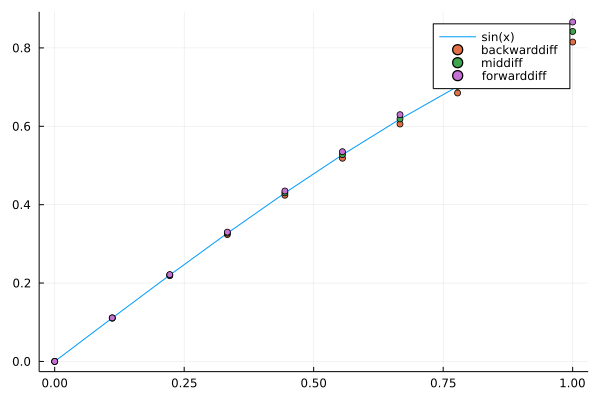

In [7]:
c = 0  # Initial condition
f(x) = cos(x)
n = 10

x = range(0, 1; length=10)
h = step(x)
A = Bidiagonal([1; fill(1/h, n-1)], fill(-1/h, n-1), :L)
ub = A \ [c; f.(x[2:end])]  # Backward differences
m = (x[1:end-1] + x[2:end]) / 2  # Midpoints
um = A \ [c; f.(m)]  # Midpoint differences
uf = A \ [c; f.(x[1:end-1])]  # Forward differences

plot(x, sin.(x); label="sin(x)")
scatter!(x, ub; label="backwarddiff")
scatter!(x, um; label="middiff")
scatter!(x, uf; label="forwarddiff")


### Euler Methods
Suppose we have a system of the form:
$$
u(0) = c \\
u'(t) - a(t)u(t) = f(t)
$$
Then we can use the following function to approximate $u(t_k)  ~ ~ ~ \forall k$ 

In [10]:
function forward_euler(a, f, c, n=1000)
    t = range(0, 1; length=n)
    h = step(t)
    u = zeros(n)
    u[1] = c  # Initial condition
    for k = 1:n-1
        u[k+1] = h*f(t[k]) + (1 + h*a(t[k]))*u[k]
    end
    return u
end

forward_euler (generic function with 3 methods)

### Two Point Boundary Value Problems